# **Political Sentiment Analysis on Social Media using the Dataset of Nepali Tweets on 2022 Election**

In [4]:
%pip install emoji seaborn matplotlib==3.7.4 pandas scikit-learn wordcloud

   ---------------------------------------- 0.0/7.5 MB ? eta -:--:--
   ----- ---------------------------------- 1.0/7.5 MB 10.1 MB/s eta 0:00:01
   -------- ------------------------------- 1.6/7.5 MB 4.0 MB/s eta 0:00:02
   ----------- ---------------------------- 2.1/7.5 MB 5.1 MB/s eta 0:00:02
   ---------------- ----------------------- 3.1/7.5 MB 4.4 MB/s eta 0:00:01
   ---------------- ----------------------- 3.1/7.5 MB 4.4 MB/s eta 0:00:01
   ---------------- ----------------------- 3.1/7.5 MB 4.4 MB/s eta 0:00:01
   ---------------- ----------------------- 3.1/7.5 MB 4.4 MB/s eta 0:00:01
   ---------------- ----------------------- 3.1/7.5 MB 4.4 MB/s eta 0:00:01
   ---------------- ----------------------- 3.1/7.5 MB 4.4 MB/s eta 0:00:01
   ---------------- ----------------------- 3.1/7.5 MB 4.4 MB/s eta 0:00:01
   ---------------- ----------------------- 3.1/7.5 MB 4.4 MB/s eta 0:00:01
   ---------------- ----------------------- 3.1/7.5 MB 4.4 MB/s eta 0:00:01
   ---------------


[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip
error: uninstall-no-record-file

× Cannot uninstall matplotlib 3.10.5
╰─> The package's contents are unknown: no RECORD file was found for matplotlib.

hint: You might be able to recover from this via: pip install --force-reinstall --no-deps matplotlib==3.10.5


In [1]:
# Importing Libraries
import os
import pandas as pd
import emoji
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample
from wordcloud import WordCloud
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score



In [4]:
# Merging the Labeled Tweets Datasets
labeled_dir = '../labeled'
all_labeled=[]

for file in os.listdir(labeled_dir):
    if file.endswith(".xlsx"):
        df = pd.read_excel(os.path.join(labeled_dir, file))
        df = df[['id', 'text', 'label']].dropna()
        all_labeled.append(df)

labeled_df = pd.concat(all_labeled, ignore_index=True)
labeled_df['id'] = labeled_df['id'].astype(str)


In [6]:
# Filtering the Main Datasets for labeled Tweets using the column 'id'
main_df = pd.read_excel("../data/nepali_tweets.xlsx")
main_df['id'] = main_df['id'].astype(str)

# Joining labeled tweets with main dataset
merged_df = pd.merge(labeled_df, main_df, on='id', how='left')

In [7]:
merged_df.head()

,id,text_x,label,Unnamed: 0,tweet_created_at,text_y,user,bio,location,hashtags,...,statuses_count,coordinates,is_quote_status,retweet_count,retweeted,lang,source,place,kwd,run_date
0,1601363673259290880,@thakurkc @mayor_harka हर्कराज साम्पाङ बालेन श...,2.0,0,2022-12-09 23:50:26+00:00,@thakurkc @mayor_harka हर्कराज साम्पाङ बालेन श...,BirshaNachhiri1,life is not easy do hard work with faithful!,NaN,[],...,894,NaN,False,0,False,ne,Twitter for Android,NaN,जनप्रतिनिधि,2022-12-10 03:39:06
1,1601226348013707008,@KanakManiDixit @Himal_Khabar अब नयाँ जनप्रतिन...,2.0,1,2022-12-09 14:44:45+00:00,@KanakManiDixit @Himal_Khabar अब नयाँ जनप्रतिन...,nirdosh2813,🇳🇵🇳🇵नेपाली हामी रहुला का कहाँ नेपालै न रहे🇳🇵🇳🇵,Nepal janakpur,[],...,10776,NaN,False,0,False,ne,Twitter for Android,NaN,जनप्रतिनिधि,2022-12-10 03:39:06
2,1601225158538117120,@damasebijaya च्याखे थापेर करारका जनप्रतिनिधिन...,2.0,2,2022-12-09 14:40:01+00:00,@damasebijaya च्याखे थापेर करारका जनप्रतिनिधिन...,Trishna50664774,"जागिर खानु छैन तेसैले नो Bio, 99% follow back","ललितपुर, नेपाल",[],...,11834,NaN,False,0,False,ne,Twitter for Android,NaN,जनप्रतिनिधि,2022-12-10 03:39:06
3,1601130318731259904,अहिले सत्तारुढ र एमाले दुवै गठबन्धनका नेताहरू ...,2.0,3,2022-12-09 08:23:10+00:00,अहिले सत्तारुढ र एमाले दुवै गठबन्धनका नेताहरू ...,nepalviewsnv,NaN,Nepal,[],...,26189,NaN,False,0,False,ne,Twitter Web App,NaN,सत्तारुढ,2022-12-10 03:39:06
4,1601069274998504960,सत्तारुढ भारतीय जनता पार्टीको गुजरातमा ऐतिहासि...,3.0,4,2022-12-09 04:20:36+00:00,सत्तारुढ भारतीय जनता पार्टीको गुजरातमा ऐतिहासि...,imagekhabar,Imagekhabar is a multi-platform news and infor...,Nepal,[],...,175220,NaN,False,0,False,ne,TweetDeck,NaN,सत्तारुढ,2022-12-10 03:39:06


In [8]:
merged_df.head()
merged_df.to_csv('../data/merged_labeled_tweets.csv', index=False)
print("Merged labeled tweets saved to '../data/merged_labeled_tweets.csv'")

Merged labeled tweets saved to '../data/merged_labeled_tweets.csv'


## Preprocessing the Tweets

### Cleaning the tweets by removing mentions, url, nepali stopwords, handling unicodes


In [ ]:

with open("../nepali_stopwords.txt", "r", encoding="utf-8") as f:
    stopwords = set(f.read().splitlines())


def clean_text(text):
    if pd.isnull(text):
        return ""
    text = emoji.replace_emoji(text, replace="")
    text = re.sub(r"[\u200c\u200d\u200e\u200f\u202a-\u202e]", "", text) 
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"#\w+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"[a-zA-Z0-9०-९।!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~]", "", text)
    text = re.sub(r"[।!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~]", "", text)
    text = re.sub(r"[a-zA-Z0-9०-९]", "", text)
    words = text.strip().split()
    words = [w for w in words if w not in stopwords and 2 <= len(w) <= 20]
    return " ".join(words)

merged_df['clean_text'] = merged_df['text_x'].apply(clean_text)

### Vocabulary Filtering the rare and long words

In [10]:
word_counts = Counter(" ".join(merged_df["clean_text"]).split())
rare_words = set([w for w, c in word_counts.items() if c < 20])

def filter_rare(text):
    return " ".join([w for w in text.split() if w not in rare_words])

merged_df['final_text'] = merged_df['clean_text'].apply(filter_rare)
merged_df.head()

,id,text_x,label,Unnamed: 0,tweet_created_at,text_y,user,bio,location,hashtags,...,is_quote_status,retweet_count,retweeted,lang,source,place,kwd,run_date,clean_text,final_text
0,1601363673259290880,@thakurkc @mayor_harka हर्कराज साम्पाङ बालेन श...,2.0,0,2022-12-09 23:50:26+00:00,@thakurkc @mayor_harka हर्कराज साम्पाङ बालेन श...,BirshaNachhiri1,life is not easy do hard work with faithful!,NaN,[],...,False,0,False,ne,Twitter for Android,NaN,जनप्रतिनिधि,2022-12-10 03:39:06,हर्कराज साम्पाङ बालेन शाहहरुको दगुरेको गाउँपाल...,साम्पाङ बालेन गाउँपालिका नगरपालिका वडामा जनप्र...
1,1601226348013707008,@KanakManiDixit @Himal_Khabar अब नयाँ जनप्रतिन...,2.0,1,2022-12-09 14:44:45+00:00,@KanakManiDixit @Himal_Khabar अब नयाँ जनप्रतिन...,nirdosh2813,🇳🇵🇳🇵नेपाली हामी रहुला का कहाँ नेपालै न रहे🇳🇵🇳🇵,Nepal janakpur,[],...,False,0,False,ne,Twitter for Android,NaN,जनप्रतिनिधि,2022-12-10 03:39:06,जनप्रतिनिधि सर्वोच्च न्यायाधीश महाभियोग हटाउनु...,जनप्रतिनिधि सर्वोच्च न्यायाधीश महाभियोग पर्छ।
2,1601225158538117120,@damasebijaya च्याखे थापेर करारका जनप्रतिनिधिन...,2.0,2,2022-12-09 14:40:01+00:00,@damasebijaya च्याखे थापेर करारका जनप्रतिनिधिन...,Trishna50664774,"जागिर खानु छैन तेसैले नो Bio, 99% follow back","ललितपुर, नेपाल",[],...,False,0,False,ne,Twitter for Android,NaN,जनप्रतिनिधि,2022-12-10 03:39:06,च्याखे थापेर करारका जनप्रतिनिधिने अत्याचार चाह...,"अत्याचार पास हो, जनप्रतिनिधि झुठो बोलेर पास पद"
3,1601130318731259904,अहिले सत्तारुढ र एमाले दुवै गठबन्धनका नेताहरू ...,2.0,3,2022-12-09 08:23:10+00:00,अहिले सत्तारुढ र एमाले दुवै गठबन्धनका नेताहरू ...,nepalviewsnv,NaN,Nepal,[],...,False,0,False,ne,Twitter Web App,NaN,सत्तारुढ,2022-12-10 03:39:06,सत्तारुढ गठबन्धनका नेताहरू रविलाई सरकारमा नल्य...,सत्तारुढ गठबन्धनका नेताहरू सरकारमा अख्तियार गर...
4,1601069274998504960,सत्तारुढ भारतीय जनता पार्टीको गुजरातमा ऐतिहासि...,3.0,4,2022-12-09 04:20:36+00:00,सत्तारुढ भारतीय जनता पार्टीको गुजरातमा ऐतिहासि...,imagekhabar,Imagekhabar is a multi-platform news and infor...,Nepal,[],...,False,0,False,ne,TweetDeck,NaN,सत्तारुढ,2022-12-10 03:39:06,सत्तारुढ भारतीय जनता पार्टीको गुजरातमा ऐतिहासि...,सत्तारुढ भारतीय जनता पार्टीको ऐतिहासिक जित


In [11]:
# Dropping the duplicates
merged_df = merged_df.drop_duplicates(subset='final_text')

In [12]:
# Annonimizing the Usernames for to remove Personal Identifiable Information (PII)
import hashlib
def hash_username(username):
    if pd.isnull(username):
        return ""
    return hashlib.sha256(username.encode('utf-8')).hexdigest()

merged_df['user'] = merged_df['user'].apply(hash_username)

In [13]:
merged_df.head()

,id,text_x,label,Unnamed: 0,tweet_created_at,text_y,user,bio,location,hashtags,...,is_quote_status,retweet_count,retweeted,lang,source,place,kwd,run_date,clean_text,final_text
0,1601363673259290880,@thakurkc @mayor_harka हर्कराज साम्पाङ बालेन श...,2.0,0,2022-12-09 23:50:26+00:00,@thakurkc @mayor_harka हर्कराज साम्पाङ बालेन श...,939c7de092e923e9e75ae70923f3da8dc9dbf606121bf7...,life is not easy do hard work with faithful!,NaN,[],...,False,0,False,ne,Twitter for Android,NaN,जनप्रतिनिधि,2022-12-10 03:39:06,हर्कराज साम्पाङ बालेन शाहहरुको दगुरेको गाउँपाल...,साम्पाङ बालेन गाउँपालिका नगरपालिका वडामा जनप्र...
1,1601226348013707008,@KanakManiDixit @Himal_Khabar अब नयाँ जनप्रतिन...,2.0,1,2022-12-09 14:44:45+00:00,@KanakManiDixit @Himal_Khabar अब नयाँ जनप्रतिन...,71ddb83740cf9cd2f94937d8af21f834f6e81304ac083e...,🇳🇵🇳🇵नेपाली हामी रहुला का कहाँ नेपालै न रहे🇳🇵🇳🇵,Nepal janakpur,[],...,False,0,False,ne,Twitter for Android,NaN,जनप्रतिनिधि,2022-12-10 03:39:06,जनप्रतिनिधि सर्वोच्च न्यायाधीश महाभियोग हटाउनु...,जनप्रतिनिधि सर्वोच्च न्यायाधीश महाभियोग पर्छ।
2,1601225158538117120,@damasebijaya च्याखे थापेर करारका जनप्रतिनिधिन...,2.0,2,2022-12-09 14:40:01+00:00,@damasebijaya च्याखे थापेर करारका जनप्रतिनिधिन...,6614a78b04284662923d2c2cf9ec10c13c3dca48f2103e...,"जागिर खानु छैन तेसैले नो Bio, 99% follow back","ललितपुर, नेपाल",[],...,False,0,False,ne,Twitter for Android,NaN,जनप्रतिनिधि,2022-12-10 03:39:06,च्याखे थापेर करारका जनप्रतिनिधिने अत्याचार चाह...,"अत्याचार पास हो, जनप्रतिनिधि झुठो बोलेर पास पद"
3,1601130318731259904,अहिले सत्तारुढ र एमाले दुवै गठबन्धनका नेताहरू ...,2.0,3,2022-12-09 08:23:10+00:00,अहिले सत्तारुढ र एमाले दुवै गठबन्धनका नेताहरू ...,52ba518166bbb3d11b6adb5c67e59ff5e5106c2feb1c8d...,NaN,Nepal,[],...,False,0,False,ne,Twitter Web App,NaN,सत्तारुढ,2022-12-10 03:39:06,सत्तारुढ गठबन्धनका नेताहरू रविलाई सरकारमा नल्य...,सत्तारुढ गठबन्धनका नेताहरू सरकारमा अख्तियार गर...
4,1601069274998504960,सत्तारुढ भारतीय जनता पार्टीको गुजरातमा ऐतिहासि...,3.0,4,2022-12-09 04:20:36+00:00,सत्तारुढ भारतीय जनता पार्टीको गुजरातमा ऐतिहासि...,601fcb344dce80db314d8cbed385cc6ddc2e5eb996b419...,Imagekhabar is a multi-platform news and infor...,Nepal,[],...,False,0,False,ne,TweetDeck,NaN,सत्तारुढ,2022-12-10 03:39:06,सत्तारुढ भारतीय जनता पार्टीको गुजरातमा ऐतिहासि...,सत्तारुढ भारतीय जनता पार्टीको ऐतिहासिक जित


In [14]:
merged_df = merged_df[merged_df['label'].isin([0, 1, 2, 3])]

In [15]:
merged_df[['id', 'final_text', 'label']].to_csv("cleaned_labeled_tweets.csv", index=False)

## Exploratory Data Analysis

### Distribution of Sentiment Labels

C:\Users\hello\AppData\Local\Temp\ipykernel_16676\1803350754.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=merged_df, x="label_name", order=label_map.values(), palette="Set2")


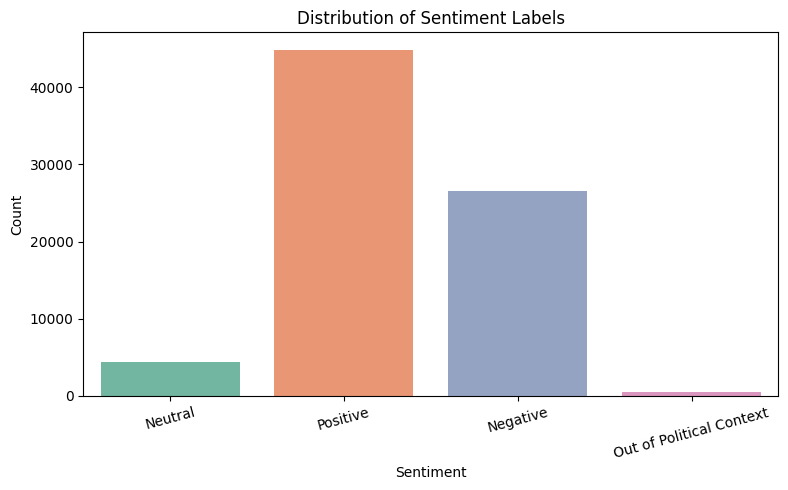

In [16]:
# Label map for readability
label_map = {
    0: "Neutral",
    1: "Positive",
    2: "Negative",
    3: "Out of Political Context"
}

merged_df["label_name"] = merged_df["label"].map(label_map)

plt.figure(figsize=(8, 5))
sns.countplot(data=merged_df, x="label_name", order=label_map.values(), palette="Set2")
plt.title("Distribution of Sentiment Labels")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

### Tweet Length Distribution


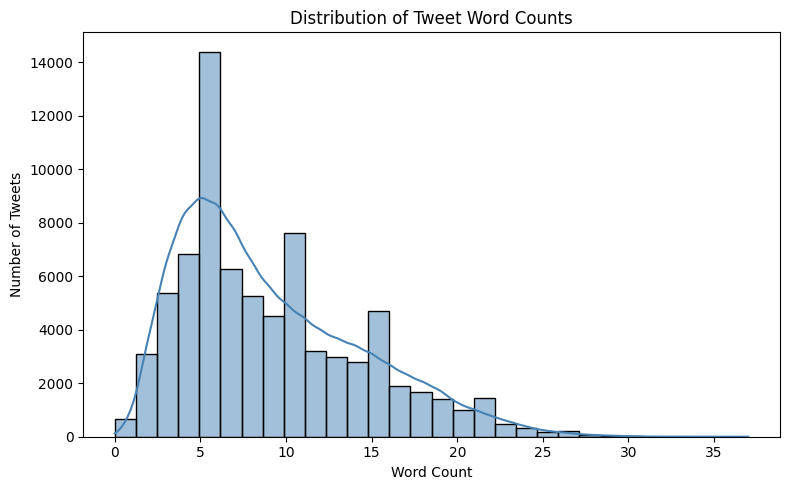

In [17]:
merged_df["text_length"] = merged_df["final_text"].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(8, 5))
sns.histplot(data=merged_df, x="text_length", bins=30, kde=True, color="steelblue")
plt.title("Distribution of Tweet Word Counts")
plt.xlabel("Word Count")
plt.ylabel("Number of Tweets")
plt.tight_layout()
plt.show()

### Average Tweet Length by Sentiment

C:\Users\hello\AppData\Local\Temp\ipykernel_16676\2542935739.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_lengths.index, y=avg_lengths.values, palette="pastel")


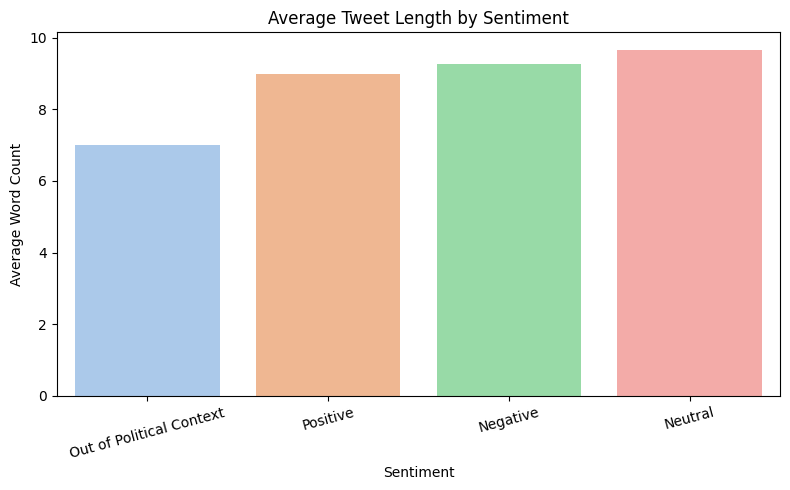

In [18]:
avg_lengths = merged_df.groupby("label_name")["text_length"].mean().sort_values()

plt.figure(figsize=(8, 5))
sns.barplot(x=avg_lengths.index, y=avg_lengths.values, palette="pastel")
plt.title("Average Tweet Length by Sentiment")
plt.ylabel("Average Word Count")
plt.xlabel("Sentiment")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


### Top Words per Sentiment

C:\Users\hello\AppData\Local\Temp\ipykernel_16676\1396009298.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="magma")
C:\Users\hello\AppData\Local\Temp\ipykernel_16676\1396009298.py:26: UserWarning: Glyph 108 (l) missing from current font.
  plt.tight_layout()
C:\Users\hello\AppData\Local\Temp\ipykernel_16676\1396009298.py:26: UserWarning: Glyph 112 (p) missing from current font.
  plt.tight_layout()
c:\Users\hello\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 108 (l) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\hello\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 112 (p) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)

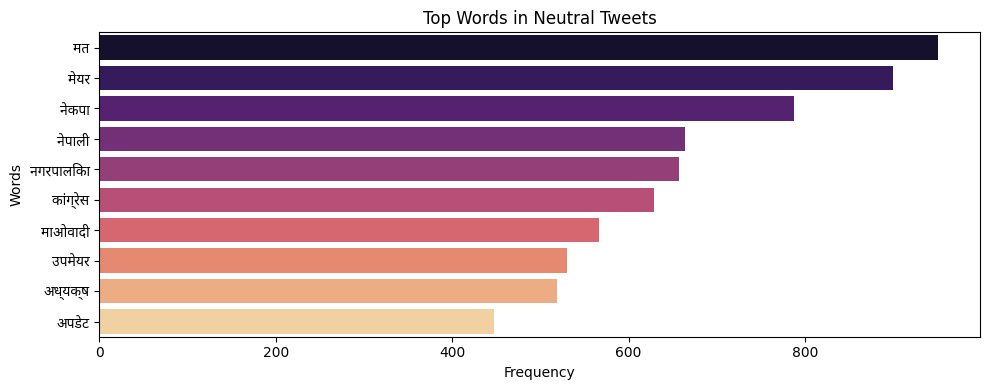

C:\Users\hello\AppData\Local\Temp\ipykernel_16676\1396009298.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="magma")
C:\Users\hello\AppData\Local\Temp\ipykernel_16676\1396009298.py:26: UserWarning: Glyph 108 (l) missing from current font.
  plt.tight_layout()
C:\Users\hello\AppData\Local\Temp\ipykernel_16676\1396009298.py:26: UserWarning: Glyph 112 (p) missing from current font.
  plt.tight_layout()
c:\Users\hello\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 108 (l) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\hello\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 112 (p) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)

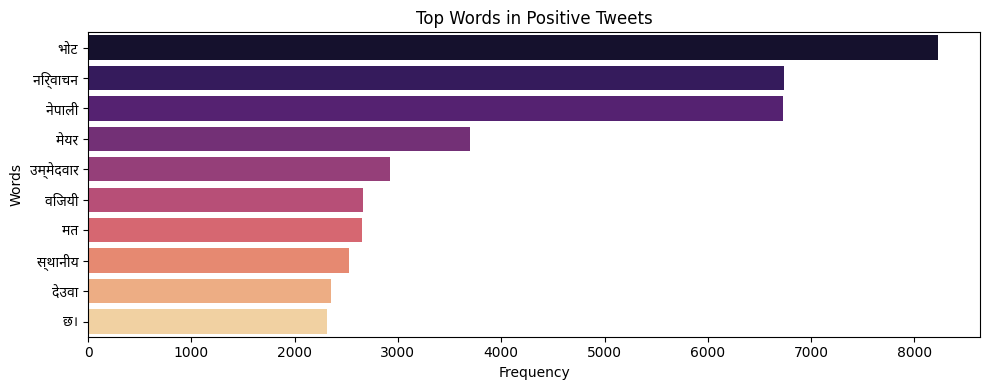

C:\Users\hello\AppData\Local\Temp\ipykernel_16676\1396009298.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="magma")
C:\Users\hello\AppData\Local\Temp\ipykernel_16676\1396009298.py:26: UserWarning: Glyph 108 (l) missing from current font.
  plt.tight_layout()
C:\Users\hello\AppData\Local\Temp\ipykernel_16676\1396009298.py:26: UserWarning: Glyph 112 (p) missing from current font.
  plt.tight_layout()
c:\Users\hello\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 108 (l) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\hello\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 112 (p) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)

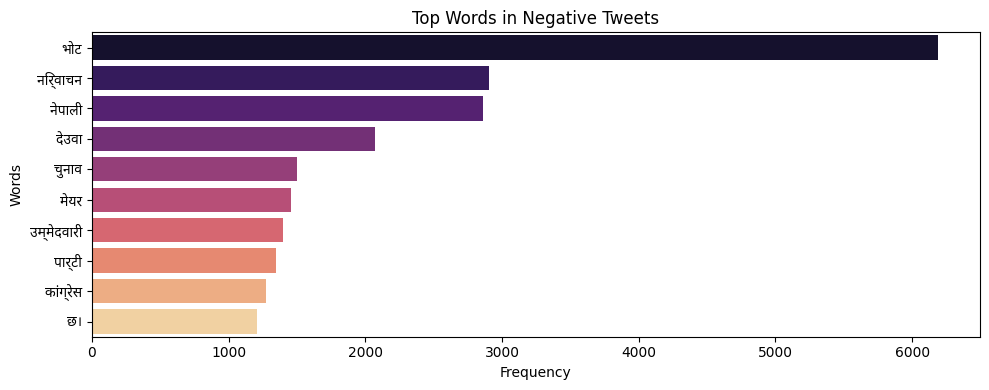

C:\Users\hello\AppData\Local\Temp\ipykernel_16676\1396009298.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="magma")
C:\Users\hello\AppData\Local\Temp\ipykernel_16676\1396009298.py:26: UserWarning: Glyph 108 (l) missing from current font.
  plt.tight_layout()
C:\Users\hello\AppData\Local\Temp\ipykernel_16676\1396009298.py:26: UserWarning: Glyph 112 (p) missing from current font.
  plt.tight_layout()
c:\Users\hello\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 108 (l) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\hello\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 112 (p) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)

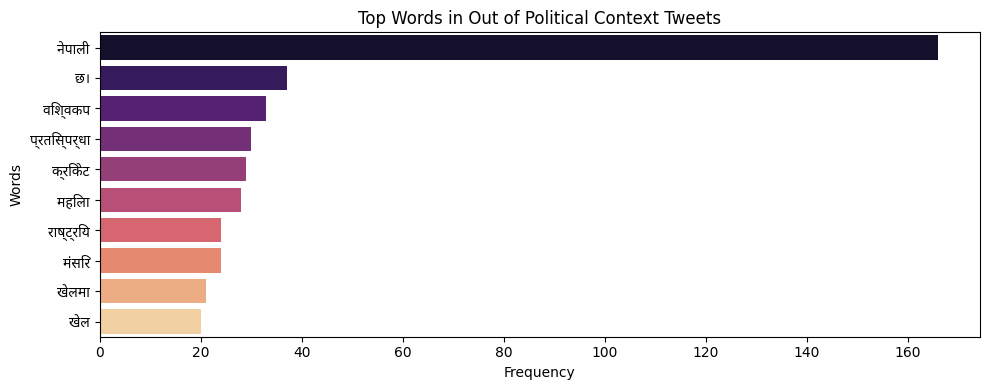

In [20]:
font_path = "../font/NotoSansDevanagari-Regular.ttf"

devanagari_font = fm.FontProperties(fname=font_path)

def get_top_words(texts, n=10):
    words = " ".join(texts).split()
    return Counter(words).most_common(n)

label_map = {
    0: "Neutral",
    1: "Positive",
    2: "Negative",
    3: "Out of Political Context"
}

for label_id, label_name in label_map.items():
    top_words = get_top_words(merged_df[merged_df["label"] == label_id]["final_text"])
    if top_words:
        words, counts = zip(*top_words)
        plt.figure(figsize=(10, 4))
        sns.barplot(x=list(counts), y=list(words), palette="magma")
        plt.title(f"Top Words in {label_name} Tweets")
        plt.xlabel("Frequency")
        plt.ylabel("Words")
        plt.yticks(fontproperties=devanagari_font)
        plt.tight_layout()
        plt.show()

## LDA (Latent Dirichlet Allocation)
Unsupervised topic modeling algorithm used to discover abstract topics in tweets

In [ ]:
%pip install git+https://github.com/anoopkunchukuttan/indic_nlp_library.git

  Cloning https://github.com/anoopkunchukuttan/indic_nlp_library.git to c:\users\hello\appdata\local\temp\pip-req-build-rqd90_cm
  Resolved https://github.com/anoopkunchukuttan/indic_nlp_library.git to commit 4cead0ae6c78fe9a19a51ef679f586206df9c476
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/anoopkunchukuttan/indic_nlp_library.git 'C:\Users\hello\AppData\Local\Temp\pip-req-build-rqd90_cm'

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [22]:
import unicodedata
from indicnlp.tokenize import indic_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [23]:
# Normalizing and tokenizing the text
def preprocess_for_topic_modeling(text):
    text = unicodedata.normalize("NFKC", text)
    return " ".join(indic_tokenize.trivial_tokenize(text, lang='ne'))

def remove_short_words(text):
    return " ".join([w for w in text.split() if len(w) > 1])

merged_df["tokenized_text"] = merged_df["clean_text"].apply(preprocess_for_topic_modeling)
merged_df["tokenized_text"] = merged_df["tokenized_text"].apply(remove_short_words)

In [24]:
# Vectorizing
vectorizer = CountVectorizer(
    max_df=0.9, 
    min_df=10,
    token_pattern=None,
    tokenizer=str.split,
    analyzer='word'
)

X = vectorizer.fit_transform(merged_df["tokenized_text"])

In [25]:
# Fitting LDA
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

LatentDirichletAllocation(n_components=5, random_state=42)

In [26]:
# Displaying topics
def display_topics(model, feature_names, n_top_words=10):
    for idx, topic in enumerate(model.components_):
        print(f"Topic #{idx+1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

display_topics(lda, vectorizer.get_feature_names_out())

Topic #1:
भोट मेयर देउवा कांग्रेस मत नेपाली प्रधानमन्त्री हाल्न गठबन्धन रुख
Topic #2:
चुनाव भोट उम्मेदवारी शुभकामना हार्दिक बिजय बधाई बालेन सफल चिन्ह
Topic #3:
निर्वाचन उम्मेदवार नेपाली नेकपा स्थानीय नगरपालिका विजयी मत कांग्रेस मेयर
Topic #4:
भोट देउवा पार्टी ओली नेपाली प्रचण्ड हो गठबन्धन माओवादी केपी
Topic #5:
नेपाली हो निर्वाचन चुनाव जनता राजनीति भोट पार्टी दल देशको


### Assigning Topics to Tweets

In [27]:

topic_probs = lda.transform(X)
merged_df["dominant_topic"] = topic_probs.argmax(axis=1)

In [28]:
merged_df.head()

,id,text_x,label,Unnamed: 0,tweet_created_at,text_y,user,bio,location,hashtags,...,source,place,kwd,run_date,clean_text,final_text,label_name,text_length,tokenized_text,dominant_topic
0,1601363673259290880,@thakurkc @mayor_harka हर्कराज साम्पाङ बालेन श...,2.0,0,2022-12-09 23:50:26+00:00,@thakurkc @mayor_harka हर्कराज साम्पाङ बालेन श...,939c7de092e923e9e75ae70923f3da8dc9dbf606121bf7...,life is not easy do hard work with faithful!,NaN,[],...,Twitter for Android,NaN,जनप्रतिनिधि,2022-12-10 03:39:06,हर्कराज साम्पाङ बालेन शाहहरुको दगुरेको गाउँपाल...,साम्पाङ बालेन गाउँपालिका नगरपालिका वडामा जनप्र...,Negative,18,हर्कराज साम्पाङ बालेन शाहहरुको दगुरेको गाउँपाल...,4
1,1601226348013707008,@KanakManiDixit @Himal_Khabar अब नयाँ जनप्रतिन...,2.0,1,2022-12-09 14:44:45+00:00,@KanakManiDixit @Himal_Khabar अब नयाँ जनप्रतिन...,71ddb83740cf9cd2f94937d8af21f834f6e81304ac083e...,🇳🇵🇳🇵नेपाली हामी रहुला का कहाँ नेपालै न रहे🇳🇵🇳🇵,Nepal janakpur,[],...,Twitter for Android,NaN,जनप्रतिनिधि,2022-12-10 03:39:06,जनप्रतिनिधि सर्वोच्च न्यायाधीश महाभियोग हटाउनु...,जनप्रतिनिधि सर्वोच्च न्यायाधीश महाभियोग पर्छ।,Negative,5,जनप्रतिनिधि सर्वोच्च न्यायाधीश महाभियोग हटाउनु...,4
2,1601225158538117120,@damasebijaya च्याखे थापेर करारका जनप्रतिनिधिन...,2.0,2,2022-12-09 14:40:01+00:00,@damasebijaya च्याखे थापेर करारका जनप्रतिनिधिन...,6614a78b04284662923d2c2cf9ec10c13c3dca48f2103e...,"जागिर खानु छैन तेसैले नो Bio, 99% follow back","ललितपुर, नेपाल",[],...,Twitter for Android,NaN,जनप्रतिनिधि,2022-12-10 03:39:06,च्याखे थापेर करारका जनप्रतिनिधिने अत्याचार चाह...,"अत्याचार पास हो, जनप्रतिनिधि झुठो बोलेर पास पद",Negative,8,च्याखे थापेर करारका जनप्रतिनिधिने अत्याचार चाह...,4
3,1601130318731259904,अहिले सत्तारुढ र एमाले दुवै गठबन्धनका नेताहरू ...,2.0,3,2022-12-09 08:23:10+00:00,अहिले सत्तारुढ र एमाले दुवै गठबन्धनका नेताहरू ...,52ba518166bbb3d11b6adb5c67e59ff5e5106c2feb1c8d...,NaN,Nepal,[],...,Twitter Web App,NaN,सत्तारुढ,2022-12-10 03:39:06,सत्तारुढ गठबन्धनका नेताहरू रविलाई सरकारमा नल्य...,सत्तारुढ गठबन्धनका नेताहरू सरकारमा अख्तियार गर...,Negative,12,सत्तारुढ गठबन्धनका नेताहरू रविलाई सरकारमा नल्य...,3
4,1601069274998504960,सत्तारुढ भारतीय जनता पार्टीको गुजरातमा ऐतिहासि...,3.0,4,2022-12-09 04:20:36+00:00,सत्तारुढ भारतीय जनता पार्टीको गुजरातमा ऐतिहासि...,601fcb344dce80db314d8cbed385cc6ddc2e5eb996b419...,Imagekhabar is a multi-platform news and infor...,Nepal,[],...,TweetDeck,NaN,सत्तारुढ,2022-12-10 03:39:06,सत्तारुढ भारतीय जनता पार्टीको गुजरातमा ऐतिहासि...,सत्तारुढ भारतीय जनता पार्टीको ऐतिहासिक जित,Out of Political Context,6,सत्तारुढ भारतीय जनता पार्टीको गुजरातमा ऐतिहासि...,4


### Visulizing Topic Distribution


C:\Users\hello\AppData\Local\Temp\ipykernel_16676\3986969434.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=merged_df, x="dominant_topic", palette="viridis")


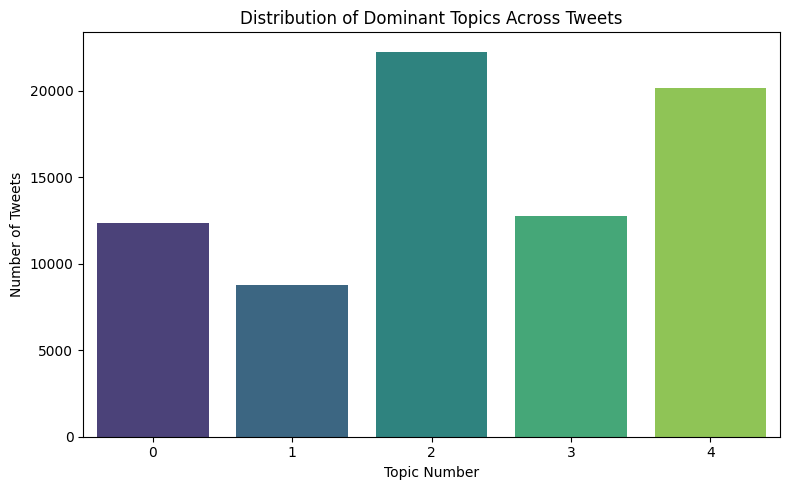

In [29]:
plt.figure(figsize=(8, 5))
sns.countplot(data=merged_df, x="dominant_topic", palette="viridis")
plt.title("Distribution of Dominant Topics Across Tweets")
plt.xlabel("Topic Number")
plt.ylabel("Number of Tweets")
plt.tight_layout()
plt.show()


### Topic Group vs Sentiment

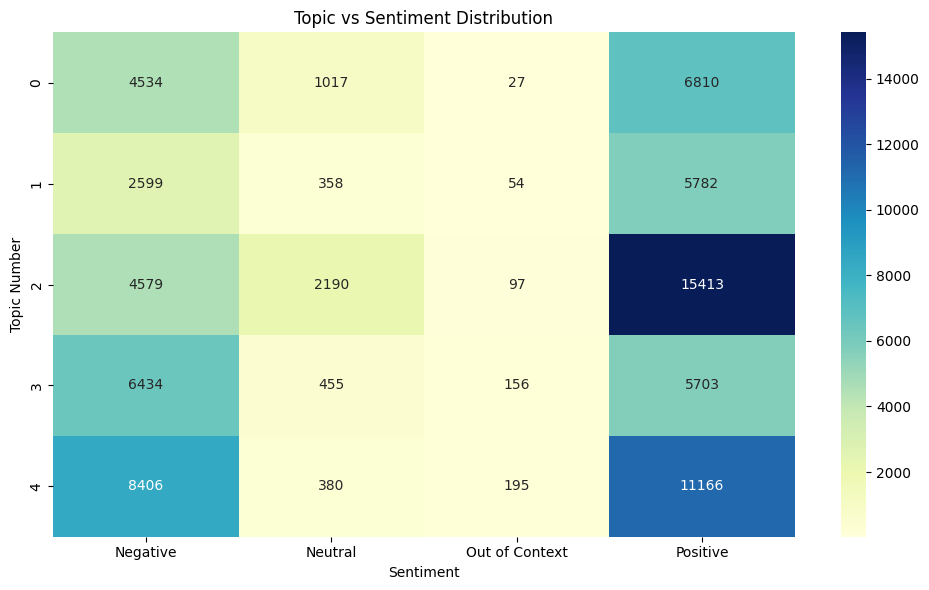

In [31]:
label_map = {0: "Neutral", 1: "Positive", 2: "Negative", 3: "Out of Context"}

merged_df["label_name"] = merged_df["label"].map(label_map)

topic_sentiment = merged_df.groupby(["dominant_topic", "label_name"]).size().unstack(fill_value=0)

# Plotting heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(topic_sentiment, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Topic vs Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Topic Number")
plt.tight_layout()
plt.show()


### Word Clouds

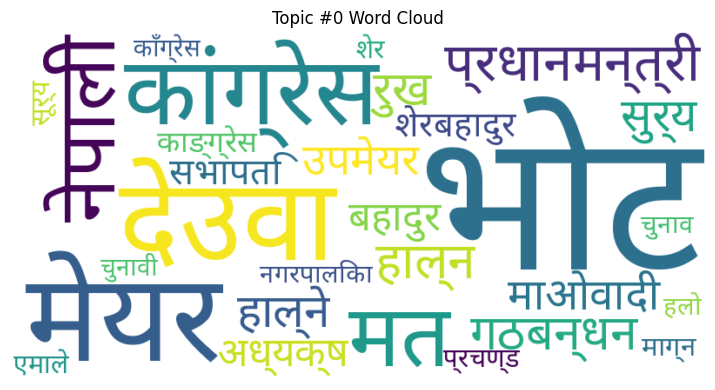

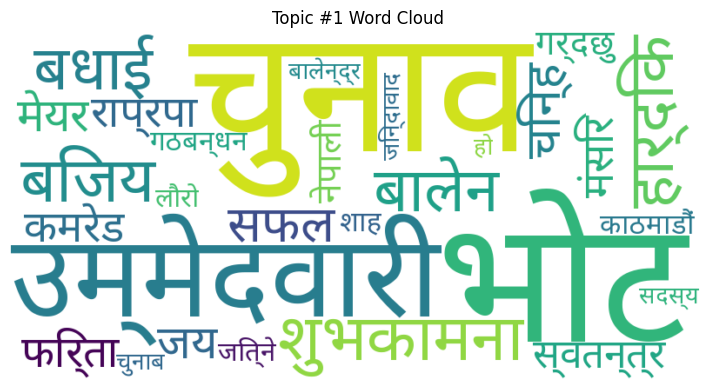

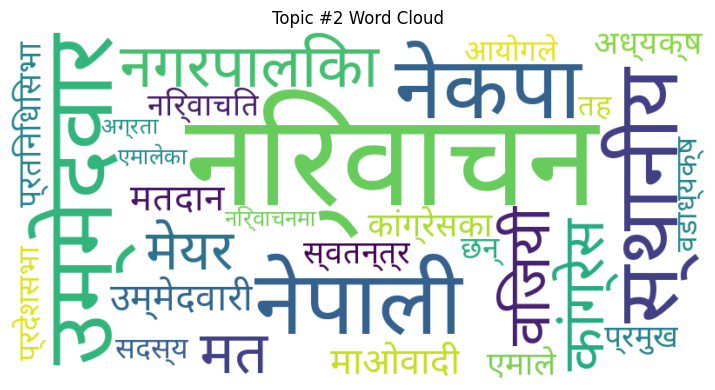

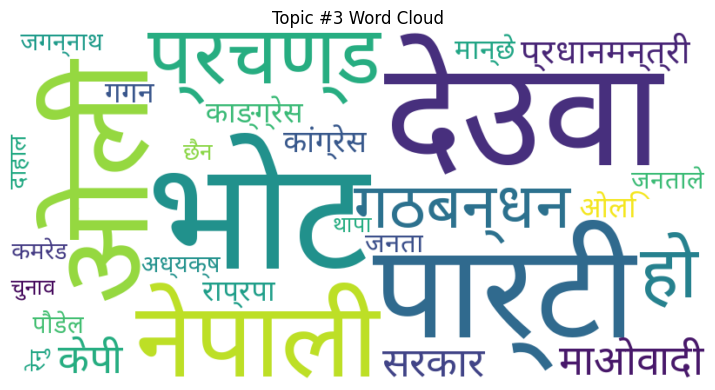

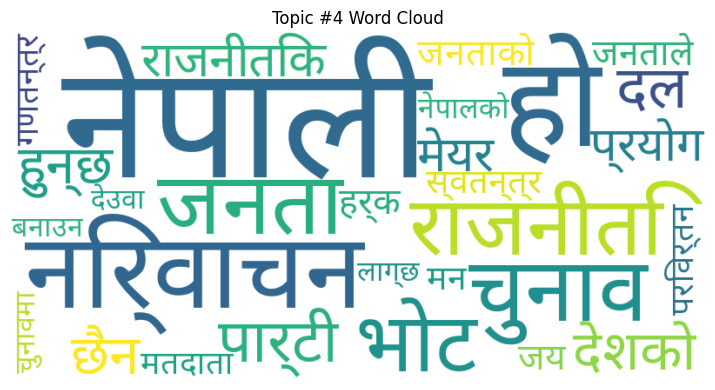

In [33]:
feature_names = vectorizer.get_feature_names_out()

for idx, topic in enumerate(lda.components_):
    plt.figure(figsize=(10, 4))
    wordcloud = WordCloud(font_path="../font/NotoSansDevanagari-Regular.ttf", 
                          background_color="white", width=800, height=400)

    top_words = {feature_names[i]: topic[i] for i in topic.argsort()[:-30:-1]}
    wordcloud.generate_from_frequencies(top_words)

    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Topic #{idx} Word Cloud")
    plt.tight_layout()
    plt.show()


## Checking for Imbalance in Sentiment Labels

Label Distribution:
Neutral (0): 4400
Positive (1): 44874
Negative (2): 26552
Out of Context (3): 529


C:\Users\hello\AppData\Local\Temp\ipykernel_16676\704414497.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[label_map.get(l, 'Unknown') for l in label_counts.index], y=label_counts.values, palette='Set2')


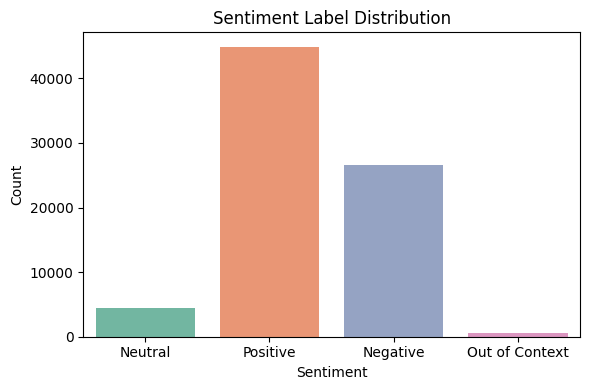

In [34]:
merged_df['label'] = merged_df['label'].astype(int)

label_counts = merged_df['label'].value_counts().sort_index()
label_map = {0: 'Neutral', 1: 'Positive', 2: 'Negative', 3: 'Out of Context'}

# Printing label distribution
print("Label Distribution:")
for label, count in label_counts.items():
    print(f"{label_map.get(label, 'Unknown')} ({label}): {count}")

# Plotting distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=[label_map.get(l, 'Unknown') for l in label_counts.index], y=label_counts.values, palette='Set2')
plt.title("Sentiment Label Distribution")
plt.ylabel("Count")
plt.xlabel("Sentiment")
plt.tight_layout()
plt.show()

The data is Imbalanced.

## Undersampling the Data

In [36]:

# Removing Unknown and Out of Context Labels
filtered_df = merged_df[merged_df['label'].isin([0, 1, 2])]

# Checking class distribution
class_counts = filtered_df['label'].value_counts()
print("Class Distribution Before Undersampling:")
print(class_counts)

min_class_count = class_counts.min()

Class Distribution Before Undersampling:
label
1    44874
2    26552
0     4400
Name: count, dtype: int64


In [37]:
# Undersampling each class to match the smallest class (Neutral)
balanced_df = pd.concat([
    resample(filtered_df[filtered_df['label'] == label],
             replace=False,
             n_samples=min_class_count,
             random_state=42)
    for label in [0, 1, 2]
])

# Shuffling the balanced DataFrame
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

print("Class Distribution After Undersampling:")
print(balanced_df['label'].value_counts())

Class Distribution After Undersampling:
label
0    4400
2    4400
1    4400
Name: count, dtype: int64


## Training Navie Bayes Model

In [38]:
# Spliting data
X_train, X_test, y_train, y_test = train_test_split(
    balanced_df['final_text'], balanced_df['label'], test_size=0.2, random_state=42, stratify=balanced_df['label'])

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000)
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

In [39]:
# Training the Model
nb_model= MultinomialNB()
nb_model.fit(X_train_vec, y_train)

MultinomialNB()

### Model Evaluation : Naive Bayes

In [40]:
y_pred = nb_model.predict(X_test_vec)
classification_report(y_test, y_pred)
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.70      0.70       880
           1       0.58      0.48      0.53       880
           2       0.56      0.65      0.60       880

    accuracy                           0.61      2640
   macro avg       0.61      0.61      0.61      2640
weighted avg       0.61      0.61      0.61      2640



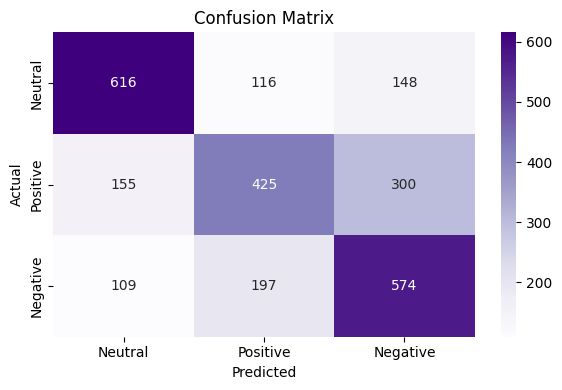

In [41]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=['Neutral', 'Positive', 'Negative'], yticklabels=['Neutral', 'Positive', 'Negative'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

## Support Vector Machine (SVM) Classifier

In [42]:

# Training SVM with different kernels
kernels = ['linear', 'rbf']
svm_results = {}

for kernel in kernels:
    print(f"\n Training SVM with {kernel} kernel...")
    start_time = time.time()
    
    # Training SVM
    svm_model = SVC(kernel=kernel, random_state=42, probability=True)
    svm_model.fit(X_train_vec, y_train)

    # Prediction
    y_pred_svm = svm_model.predict(X_test_vec)
    
    # Evaluation
    accuracy = accuracy_score(y_test, y_pred_svm)
    training_time = time.time() - start_time
    
    svm_results[kernel] = {
        'model': svm_model,
        'predictions': y_pred_svm,
        'accuracy': accuracy,
        'training_time': training_time
    }
    
    print(f" {kernel.upper()} SVM Accuracy: {accuracy:.4f}")
    print(f" Training Time: {training_time:.2f} seconds")
    print(f"\nClassification Report ({kernel.upper()} SVM):")
    print(classification_report(y_test, y_pred_svm, target_names=['Neutral', 'Positive', 'Negative']))


 Training SVM with linear kernel...
 LINEAR SVM Accuracy: 0.6049
 Training Time: 24.36 seconds

Classification Report (LINEAR SVM):
              precision    recall  f1-score   support

     Neutral       0.73      0.64      0.68       880
    Positive       0.58      0.49      0.53       880
    Negative       0.53      0.68      0.60       880

    accuracy                           0.60      2640
   macro avg       0.62      0.60      0.61      2640
weighted avg       0.62      0.60      0.61      2640


 Training SVM with rbf kernel...
 RBF SVM Accuracy: 0.6288
 Training Time: 31.94 seconds

Classification Report (RBF SVM):
              precision    recall  f1-score   support

     Neutral       0.76      0.69      0.72       880
    Positive       0.60      0.53      0.56       880
    Negative       0.55      0.67      0.61       880

    accuracy                           0.63      2640
   macro avg       0.64      0.63      0.63      2640
weighted avg       0.64      0.63   

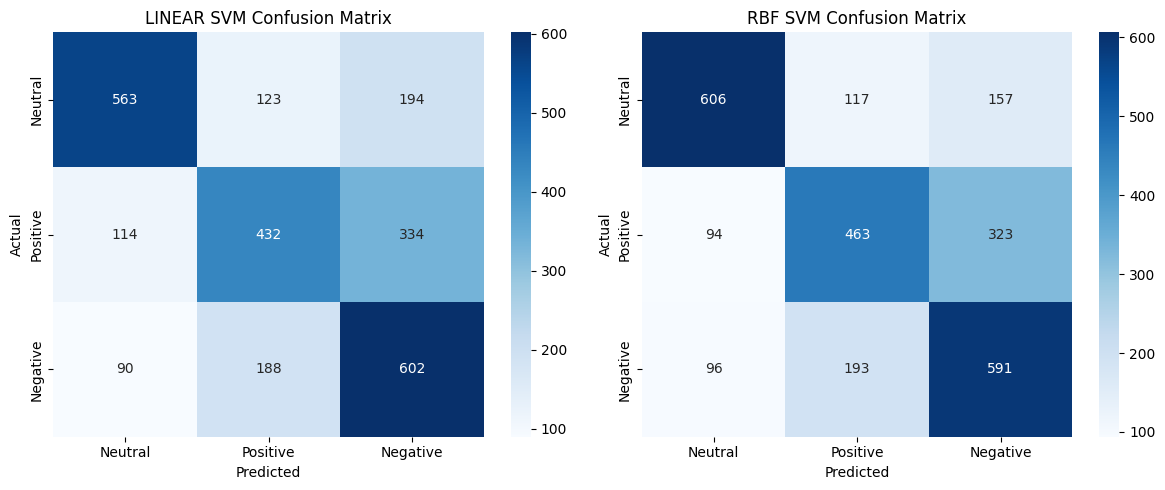

In [43]:
# Confusion Matrices for SVM models
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for idx, (kernel, results) in enumerate(svm_results.items()):
    cm = confusion_matrix(y_test, results['predictions'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Neutral', 'Positive', 'Negative'], 
                yticklabels=['Neutral', 'Positive', 'Negative'])
    axes[idx].set_title(f'{kernel.upper()} SVM Confusion Matrix')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

plt.tight_layout()
plt.show()

## Random Forest Classifier

In [48]:

# Training Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_vec.toarray(), y_train)



RandomForestClassifier(n_jobs=-1, random_state=42)

In [49]:
# Prediction
y_pred_rf = rf_model.predict(X_test_vec.toarray())

# Evaluation
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_training_time = time.time() - start_time

print(f" Random Forest Accuracy: {rf_accuracy:.4f}")
print(f" Training Time: {rf_training_time:.2f} seconds")
print(f"\nClassification Report (Random Forest):")
print(classification_report(y_test, y_pred_rf, target_names=['Neutral', 'Positive', 'Negative']))

# Feature importance
feature_names = tfidf.get_feature_names_out()
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n Top 10 Most Important Features:")
print(feature_importance.head(10))

 Random Forest Accuracy: 0.6057
 Training Time: 34.34 seconds

Classification Report (Random Forest):
              precision    recall  f1-score   support

     Neutral       0.69      0.72      0.70       880
    Positive       0.56      0.49      0.52       880
    Negative       0.56      0.61      0.58       880

    accuracy                           0.61      2640
   macro avg       0.60      0.61      0.60      2640
weighted avg       0.60      0.61      0.60      2640


 Top 10 Most Important Features:
     feature  importance
651     नगरप    0.023177
465       जय    0.016957
23       अपड    0.016950
896       यर    0.016671
225       एम    0.013586
393       चन    0.012411
193       उम    0.012021
943       रत    0.011636
341      गणन    0.011621
1142      सम    0.011168


## Logistic Regression Classifier

In [50]:

print(" Training Logistic Regression Classifier...")
start_time = time.time()

# Training Logistic Regression with different regularization
lr_results = {}
regularizations = [0.1, 1.0, 10.0]

for C in regularizations:
    print(f"\n Training with C={C}...")
    
    # Training model
    lr_model = LogisticRegression(C=C, random_state=42, max_iter=1000)
    lr_model.fit(X_train_vec, y_train)
    
    # Prediction
    y_pred_lr = lr_model.predict(X_test_vec)
    
    # Evaluation
    lr_accuracy = accuracy_score(y_test, y_pred_lr)
    
    lr_results[C] = {
        'model': lr_model,
        'predictions': y_pred_lr,
        'accuracy': lr_accuracy
    }
    
    print(f" Logistic Regression (C={C}) Accuracy: {lr_accuracy:.4f}")

# Using best performing model for detailed analysis
best_C = max(lr_results.keys(), key=lambda k: lr_results[k]['accuracy'])
best_lr_model = lr_results[best_C]['model']
best_lr_pred = lr_results[best_C]['predictions']

lr_training_time = time.time() - start_time
print(f"\n Total Training Time: {lr_training_time:.2f} seconds")
print(f"\n Best Model: Logistic Regression (C={best_C})")
print(f"Classification Report (Best Logistic Regression):")
print(classification_report(y_test, best_lr_pred, target_names=['Neutral', 'Positive', 'Negative']))

 Training Logistic Regression Classifier...

 Training with C=0.1...
 Logistic Regression (C=0.1) Accuracy: 0.6098

 Training with C=1.0...
 Logistic Regression (C=1.0) Accuracy: 0.6038

 Training with C=10.0...
 Logistic Regression (C=10.0) Accuracy: 0.5936

 Total Training Time: 0.30 seconds

 Best Model: Logistic Regression (C=0.1)
Classification Report (Best Logistic Regression):
              precision    recall  f1-score   support

     Neutral       0.74      0.65      0.69       880
    Positive       0.59      0.47      0.52       880
    Negative       0.54      0.71      0.61       880

    accuracy                           0.61      2640
   macro avg       0.62      0.61      0.61      2640
weighted avg       0.62      0.61      0.61      2640



## Gradient Boosting Classifier (XGBoost)

In [38]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [51]:
import xgboost as xgb

# Training XGBoost
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    eval_metric='mlogloss'
)

xgb_model.fit(X_train_vec, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [52]:
# Prediction
y_pred_xgb = xgb_model.predict(X_test_vec)

# Evaluation
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
xgb_training_time = time.time() - start_time

print(f" XGBoost Accuracy: {xgb_accuracy:.4f}")
print(f" Training Time: {xgb_training_time:.2f} seconds")
print(f"\nClassification Report (XGBoost):")
print(classification_report(y_test, y_pred_xgb, target_names=['Neutral', 'Positive', 'Negative']))

# Feature importance for XGBoost
xgb_feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n Top 10 Most Important Features (XGBoost):")
print(xgb_feature_importance.head(10))

 XGBoost Accuracy: 0.5833
 Training Time: 34.36 seconds

Classification Report (XGBoost):
              precision    recall  f1-score   support

     Neutral       0.77      0.60      0.67       880
    Positive       0.56      0.40      0.47       880
    Negative       0.50      0.75      0.60       880

    accuracy                           0.58      2640
   macro avg       0.61      0.58      0.58      2640
weighted avg       0.61      0.58      0.58      2640


 Top 10 Most Important Features (XGBoost):
    feature  importance
23      अपड    0.026748
341     गणन    0.024108
651    नगरप    0.021022
837   मतगणन    0.010644
878     यकर    0.010531
178      उप    0.009971
465      जय    0.009783
434     जगन    0.009710
816    भरतप    0.009583
959     रबह    0.008958


## Comparison of Conventional Models

Comparing All Machine Learning Models

In [54]:

y_pred_nb = nb_model.predict(X_test_vec)

models_comparison = {
    'Naive Bayes': {
        'predictions': y_pred_nb,
        'training_time': 'Fast (~seconds)'
    },
    'Linear SVM': {
        'predictions': svm_results['linear']['predictions'],
        'training_time': svm_results['linear']['training_time']
    },
    'RBF SVM': {
        'predictions': svm_results['rbf']['predictions'],
        'training_time': svm_results['rbf']['training_time']
    },
    'Random Forest': {
        'predictions': y_pred_rf,
        'training_time': rf_training_time
    },
    'Logistic Regression': {
        'predictions': best_lr_pred,
        'training_time': lr_training_time
    },
    'XGBoost': {
        'predictions': y_pred_xgb,
        'training_time': xgb_training_time
    }
}

# Calculating metrics for all models
comparison_results = []

for model_name, results in models_comparison.items():
    y_pred = results['predictions']
    
    # Calculating metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    comparison_results.append({
        'Model': model_name,
        'Accuracy': round(accuracy, 4),
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1-Score': round(f1, 4),
        'Training Time (s)': results['training_time'] if isinstance(results['training_time'], (int, float)) else results['training_time']
    })

# Creating comparison DataFrame
comparison_df = pd.DataFrame(comparison_results)
comparison_df = comparison_df.sort_values('F1-Score', ascending=False)

print(" MODEL PERFORMANCE COMPARISON")
print("=" * 50)
print(comparison_df.to_string(index=False))



 MODEL PERFORMANCE COMPARISON
              Model  Accuracy  Precision  Recall  F1-Score Training Time (s)
            RBF SVM    0.6288     0.6374  0.6288    0.6297         31.941233
        Naive Bayes    0.6117     0.6125  0.6117    0.6096   Fast (~seconds)
Logistic Regression    0.6098     0.6221  0.6098    0.6085          0.301575
         Linear SVM    0.6049     0.6161  0.6049    0.6050         24.362126
      Random Forest    0.6057     0.6044  0.6057    0.6035         34.342643
            XGBoost    0.5833     0.6104  0.5833    0.5800         34.359588


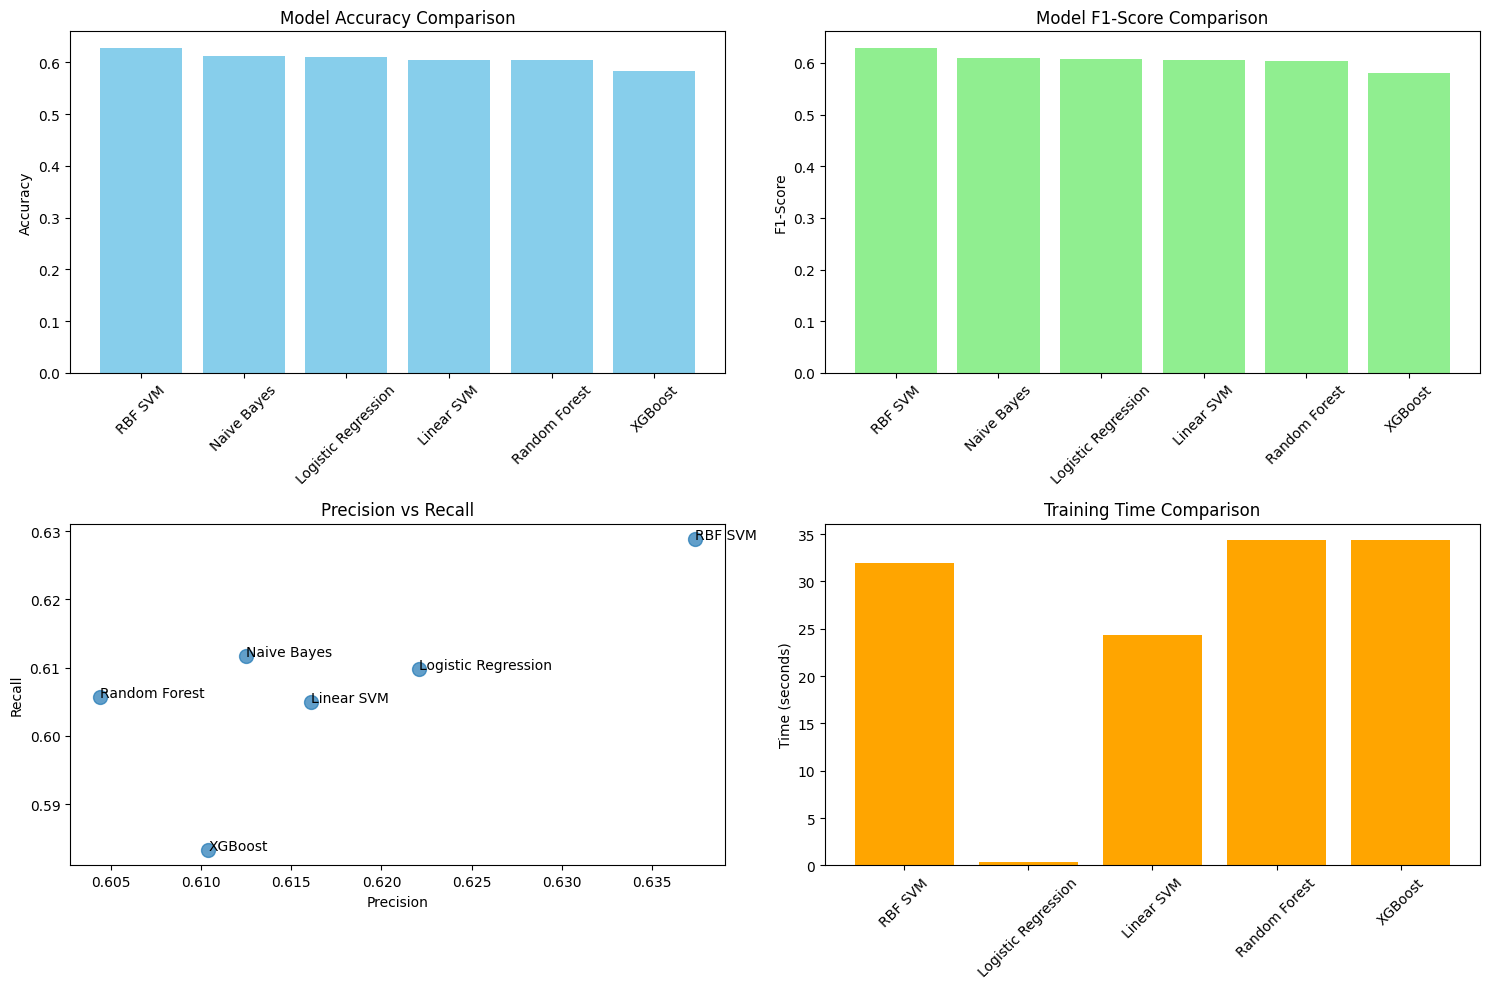

In [55]:
# Visualizing model comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Accuracy comparison
axes[0,0].bar(comparison_df['Model'], comparison_df['Accuracy'], color='skyblue')
axes[0,0].set_title('Model Accuracy Comparison')
axes[0,0].set_ylabel('Accuracy')
axes[0,0].tick_params(axis='x', rotation=45)

# F1-Score comparison
axes[0,1].bar(comparison_df['Model'], comparison_df['F1-Score'], color='lightgreen')
axes[0,1].set_title('Model F1-Score Comparison')
axes[0,1].set_ylabel('F1-Score')
axes[0,1].tick_params(axis='x', rotation=45)

# Precision vs Recall
axes[1,0].scatter(comparison_df['Precision'], comparison_df['Recall'], s=100, alpha=0.7)
for i, model in enumerate(comparison_df['Model']):
    axes[1,0].annotate(model, (comparison_df['Precision'].iloc[i], comparison_df['Recall'].iloc[i]))
axes[1,0].set_xlabel('Precision')
axes[1,0].set_ylabel('Recall')
axes[1,0].set_title('Precision vs Recall')

# Training time comparison
numeric_times = comparison_df[comparison_df['Training Time (s)'].apply(lambda x: isinstance(x, (int, float)))]
if not numeric_times.empty:
    axes[1,1].bar(numeric_times['Model'], numeric_times['Training Time (s)'], color='orange')
    axes[1,1].set_title('Training Time Comparison')
    axes[1,1].set_ylabel('Time (seconds)')
    axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Class wise Performance

 Best Overall Model: RBF SVM
Detailed Classification Report:
              precision    recall  f1-score   support

     Neutral       0.76      0.69      0.72       880
    Positive       0.60      0.53      0.56       880
    Negative       0.55      0.67      0.61       880

    accuracy                           0.63      2640
   macro avg       0.64      0.63      0.63      2640
weighted avg       0.64      0.63      0.63      2640



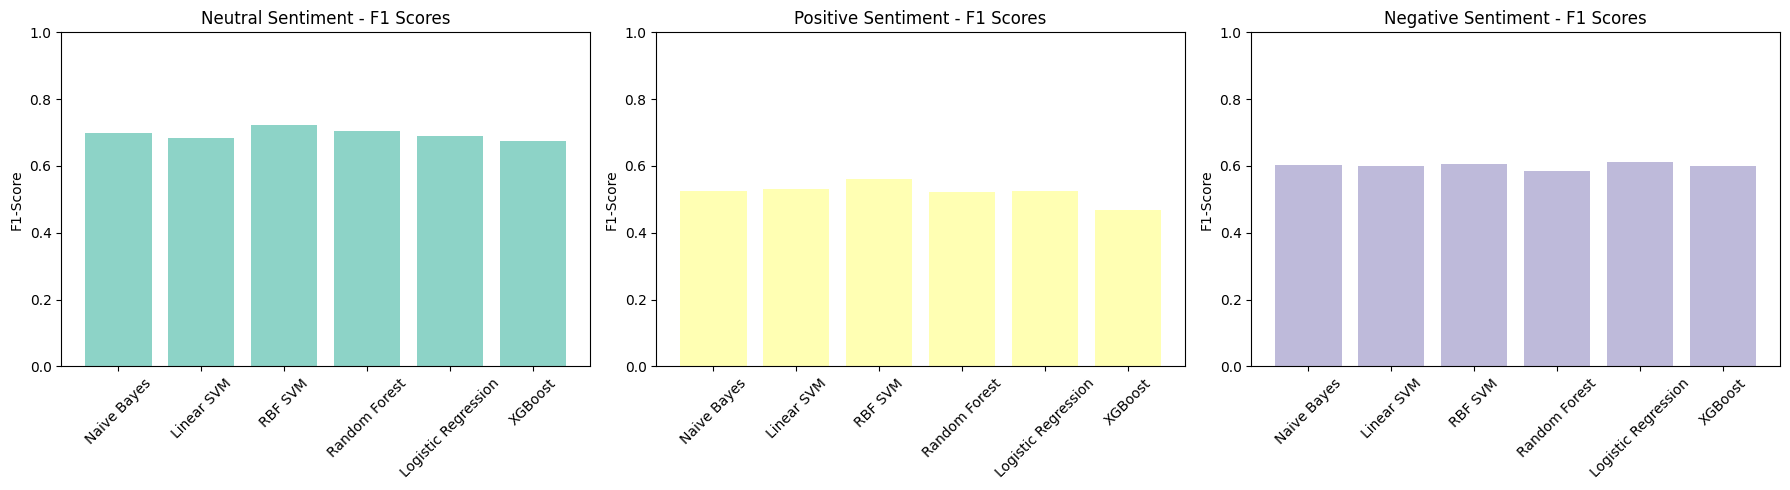

In [56]:
best_model_name = comparison_df.iloc[0]['Model']
best_predictions = models_comparison[best_model_name]['predictions']

print(f" Best Overall Model: {best_model_name}")
print(f"Detailed Classification Report:")
print(classification_report(y_test, best_predictions, target_names=['Neutral', 'Positive', 'Negative']))

class_performance = {}
target_names = ['Neutral', 'Positive', 'Negative']

for model_name, results in models_comparison.items():
    y_pred = results['predictions']
    class_report = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
    
    for i, class_name in enumerate(target_names):
        if class_name not in class_performance:
            class_performance[class_name] = {}
        class_performance[class_name][model_name] = {
            'precision': class_report[class_name]['precision'],
            'recall': class_report[class_name]['recall'],
            'f1-score': class_report[class_name]['f1-score']
        }

# Visualizing class-wise performance
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (class_name, metrics) in enumerate(class_performance.items()):
    models = list(metrics.keys())
    f1_scores = [metrics[model]['f1-score'] for model in models]
    
    axes[idx].bar(models, f1_scores, color=plt.cm.Set3(idx))
    axes[idx].set_title(f'{class_name} Sentiment - F1 Scores')
    axes[idx].set_ylabel('F1-Score')
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].set_ylim(0, 1)

plt.tight_layout()
plt.show()

## Multilingual BERT Sentiment Classifier

In [ ]:
%pip uninstall transformers tensorflow keras tf-keras -y
%pip install torch torchvision
%pip install transformers[torch] --upgrade

Found existing installation: transformers 4.53.2
Uninstalling transformers-4.53.2:
  Successfully uninstalled transformers-4.53.2
Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached transformers-4.53.2-py3-none-any.whl.metadata (40 kB)
Using cached transformers-4.53.2-py3-none-any.whl (10.8 MB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [40]:
%pip uninstall tensorflow keras keras-nightly tf_keras -y
%pip install transformers[torch] --upgrade


Found existing installation: tensorflow 2.19.0
Uninstalling tensorflow-2.19.0:
  Successfully uninstalled tensorflow-2.19.0
Found existing installation: keras 3.10.0
Uninstalling keras-3.10.0:
  Successfully uninstalled keras-3.10.0
Found existing installation: tf_keras 2.19.0
Uninstalling tf_keras-2.19.0:
  Successfully uninstalled tf_keras-2.19.0
Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [57]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

print(" HuggingFace Transformers + PyTorch loaded successfully!")


c:\Users\hello\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


 HuggingFace Transformers + PyTorch loaded successfully!


In [43]:
# Tokenizer and Dataset Setup

from transformers import AutoTokenizer
from datasets import Dataset

tokenizer=AutoTokenizer.from_pretrained("xlm-roberta-base")

def tokenize_fn(examples):
    return tokenizer(examples["text"], truncation=True)

def tokenize_fn(examples):
    return tokenizer(examples["text"], truncation=True)

df_balanced = merged_df[["final_text", "label"]].rename(columns={"final_text": "text"})
df_balanced=df_balanced[df_balanced['label'].isin([0,1,2])]
hf_dataset = Dataset.from_pandas(df_balanced)

tokenized_ds = hf_dataset.map(tokenize_fn, batched=True)

Map: 100%|██████████| 75826/75826 [00:02<00:00, 35246.70 examples/s]


In [37]:
%pip install accelerate -U



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [38]:
%pip uninstall tensorflow tensorboard keras tf_keras -y


Found existing installation: tensorboard 2.19.0
Uninstalling tensorboard-2.19.0:
  Successfully uninstalled tensorboard-2.19.0
Note: you may need to restart the kernel to use updated packages.


In [39]:
%pip install torch torchvision torchaudio
%pip install tensorboard


INFO: pip is looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
   -------- ------------------------------- 0.5/2.4 MB 4.2 MB/s eta 0:00:01
   ----------------- ---------------------- 1.0/2.4 MB 4.2 MB/s eta 0:00:01
   -------------------------- ------------- 1.6/2.4 MB 2.8 MB/s eta 0:00:01
   ---------------------------------------- 2.4/2.4 MB 3.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached tensorboard-2.19.0-py3-none-any.whl.metadata (1.8 kB)
Using cached tensorboard-2.19.0-py3-none-any.whl (5.5 MB)
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.17.0 requires keras>=3.2.0, which is not installed.
tensorflow-intel 2.17.0 requires ml-dtypes<0.5.0,>=0.3.1, but you have ml-dtypes 0.5.1 which is incompatible.
tensorflow-intel 2.17.0 requires tensorboard<2.18,>=2.17, but you have tensorboard 2.19.0 which is incompatible.

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# Training the Model

from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

# Loading the model
model = AutoModelForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=3)

# Defining metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Train-test split
split_ds = tokenized_ds.train_test_split(test_size=0.2)

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    save_strategy="epoch",
    report_to=[],
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=split_ds["train"],
    eval_dataset=split_ds["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\hello\AppData\Local\Temp\ipykernel_28192\204954798.py:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

Training the RoBERTa Model required significant hardware resource while doing it locally. So, Further work is done in the bert_for_nepali_sentiment_emotion.ipynb file.